IA & Data science (LU3IN0226) -- 2019-2020
--------
*&copy; Equipe pédagogique: Gauvain Bourgne, Vincent Guigue, Marie-Jeanne Lesot, Christophe Marsala, Olivier Schwander.*


# TD-TME05: visualisation et expérimentations

<font size="+1" color="RED">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

*MARZOUKI Amine & KHIATI Rezkellah Noureddine*

<font color="RED" size="+1">**[Q]**</font> **Renommer ce fichier ipython**

Tout en haut de cette page, cliquer sur <tt>tme-05</tt> et rajouter à la suite de <tt>tme-05</tt> les noms des membres du binômes séparés par un tiret.

Par exemple, pour le binôme Luke Skywalker et Han Solo, le nom de fichier devient `tme-05-Skywalker-Solo`

Penser à sauvegarder fréquemment le fichier en cours de travail :
- soit en cliquant sur l'icône "disquette"
- soit par la combinaison de touches [Ctrl]-S

<font color="RED" size="+1">**[Q]**</font> **Mise à jour de la librairie `iads`**

En premier lieu, vérifier que votre librairie `iads` est bien à jour : elle doit maintenant contenir toutes les fonctions et classes mises au point et testées dans les tme précédents. Une fois à jour, importer la librairie pour pouvoir l'utiliser dans ce notebook.

In [7]:
# Importation des librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire frère du répertoire courant !

# Importation de la librairie iads
import iads as iads

# importation de Classifiers
from iads import Classifiers as cl

# importation de utils
from iads import utils as ut

from itertools import chain

### Objectifs de ce TME

L'objectif de ce TME est de terminer les implémentations des algorithmes du perceptron et sa variante à noyau ainsi que les $k$ plus proches voisins, de réaliser un ensemble d'expérimentations pour les comparer, et de mettre en oeuvre des outils de visualisation.

En reprenant la fonction écrite dans les TME précédents, on commence par générer un dataset pour tester les fonctions.

Le dataset généré avec  20 lignes de  2 colonnes.


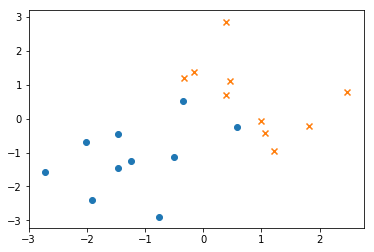

In [8]:
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

# Exemple d'utilisation:

data_desc, data_label = ut.genere_dataset_gaussian(np.array([1,1]),np.array([[1,0],[0,1]]), \
                                                   np.array([-1,-1]),np.array([[1,0],[0,1]]),\
                                                   10)

print("Le dataset généré avec ", np.shape(data_desc)[0], "lignes de ", np.shape(data_desc)[1], "colonnes.")

# Affichage :
ut.plot2DSet(data_desc,data_label)


## Expérimentations

Pour expérimenter un classifieur, il est nécessaire de posséder deux datasets distincts: 
- le dataset d'apprentissage, qui se compose donc de 2 arrays: `train_desc` et `train_labels`
- et le dataset de test, qui se compose de 2 arrays: `test_desc` et `test_labels`. 


On commence par construire le classifieur avec le dataset d'apprentisage, puis, on évalue sa performance en 2 temps :
- on calcule son **accuracy d'apprentissage** qui est l'accuracy obtenue sur le dataset d'apprentissage 
- on calcule son **accuracy de test** qui est l'accuracy obtenue sur le dataset de test

La première valeur mesure combien le classifieur a appris les données d'apprentissage, la deuxième valeur mesure sa performance en généralisation.

### Retour sur la validation croisée (correctif)

Le principe (corrigé par rapport à ce qui a été dit dans le TME 04) d'une expérimentation par validation croisée (ou *cross-validation*) est le suivant.

<ol>
    <li>Choisir un algorithme de construction de classifieur à évaluer</li>
    <li>Générer un dataset suffisamment grand. Soit $DS$ ce dataset</li>
    <li>Découper $DS$ en 10 datasets de taille égale tels qu'ils contiennent tous la même proportion d'exemples de chaque classe que $DS$, les exemples pour constituer chacun de ces datasets sont tirés aléatoirement parmi les exemples $DS$ par un tirage <b>sans remise</b>. On appelle $DS0$, $DS1$,..., $DS9$ ces 10 datasets.</li>
    <li>Construire un classifieur : <font color="RED">on prend $DS0$ comme <b>dataset de test</b> et on regroupe les 9 autres datasets $DS1$,...,$DS9$ pour constituer le <b>dataset d'apprentissage</b></font>. Les 9 datasets utilisés pour construire le classifieur servent à évaluer l'accuracy d'apprentissage $accA_0$ et le dataset $DS0$ sert à évaluer l'accuracy de test $accT_0$ de ce classifieur.</li>
    <li>Construire un nouveau classifier en prenant $DS1$ comme dataset de test et les autres datasets $DS0$, $DS2$,...,$DS9$ comme dataset d'apprentissage et évaluer l'accuracy d'apprentissage $accA_1$ et l'accuracy de test $accT_1$ de ce classifieur.</li>
    <li>etc. Chaque dataset $DSi$ sert <b>une fois comme dataset de test</b> et <b>9 fois comme dataset d'apprentissage</b></li>
</ol>
    
Au final, on obtient donc 10 valeurs d'accuracy d'apprentissage et 10 valeurs d'accuracy de test, la performance globale de l'algorithme du classifieur choisi est obtenue en donnant:
- la moyenne des accuracies de test $\frac{1}{10}\sum_{i=0}^{9} accT_i$
- l'écart type des accuracies de test $accT_0$, ..., $accT_{9}$

De même, la moyenne et l'écart type des accuracies d'apprentissage peut être aussi fournie.

*Remarque*: ici, comme on choisit de découper $DS$ en $10$ datasets, on parle de *validation croisée en 10 paquets* (en anglais: *10-folds cross-validation*). Dans d'autres cas, on peut choisir de réaliser un découpage avec un nombre de datasets différents. On parle alors de *validation croisée en m paquets* avec $m$ un nombre entier supérieur ou égal à 2.


<font color="RED" size="+1">**[Q]**</font> Compléter la fonction suivante qui, étant donné un classifieur $C$, un dataset $DS$ (donné sous la forme d'un tuple (descriptions, labels)) et un entier $m$, réalise une validation croisée en $m$ paquets et rend le quadruplet composé de 2 tuples: le premier tuple donne la moyenne et l'écart type d'apprentissage, le second tuple donne la moyenne et l'écart type de test.

<b>Astuce:</b> ne pas dupliquer les dataset : travailler sur des listes d'indices qui sont ensuite utilisées pour faire des extractions à partir des arrays représentant le dataset.

In [9]:
def crossvalidation(C, DS, m=10):
    """ Classifieur * tuple[array, array] * int -> tuple[tuple[float,float], tuple[float,float]]
        Hypothèse: m>0
        Par défaut, m vaut 10
    """
    
    
    ############################ IMPORTANT ####################################
    # 𝐷𝑆1 comme dataset de test et les autres datasets 𝐷𝑆0, 𝐷𝑆3,...,𝐷𝑆9 comme dataset pour apprentissage 
    # each iteration we pick 1 for testing and the others for training
    ###########################################################################
    
    data_desc, data_labels = DS[0], DS[1]
    indices = [i for i in range(len(data_desc))]
    train_accs = []
    test_accs = []
    m_indices = []
    
    length = len(data_desc) // m
    
    for i in range(m): # we're not treating the case where m%len(DS) != 0 (if the rest has a size = 1, it'll kill the avg)
        # random tirage
        np.random.shuffle(indices)
        
        m_indices.append([i for i in indices[:length]])

        # remove the first length indices so that we don't take the same description twice
        for j in range(length):
            indices.pop(0)
    
    for test_index in range(m):
        # getting the training indices in each iteration
        train_indices = list(chain.from_iterable([m_indices[i] for i in range(m) if i != test_index]))
        
        # append training accuracy to the training_set
        C.train(data_desc[train_indices], data_labels[train_indices])   
        train_accs.append(C.accuracy(data_desc[train_indices], data_labels[train_indices]))

        # append test accuracy to the test_set
        test_accs.append(C.accuracy(data_desc[m_indices[test_index]], data_labels[m_indices[test_index]]))    
        
    print("[Info debug] liste accuracies Apprentissage: ", train_accs)
    print("[Info debug] liste accuracies Test         : ", test_accs)
    train_accs = np.array(train_accs)
    test_accs = np.array(test_accs)
    
    return (train_accs.mean(), train_accs.std()), (test_accs.mean(), test_accs.std())

In [10]:
# Exemple d'utilisation:

# Un autre exemple d'utilisation :
knn = cl.ClassifierKNN(2,1)

res_apprentissage, res_test = crossvalidation(knn, (data_desc, data_label), 10)

print("(moyenne, std) pour apprentissage :", res_apprentissage)
print("(moyenne, std) pour test          :", res_test)

[Info debug] liste accuracies Apprentissage:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[Info debug] liste accuracies Test         :  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0]
(moyenne, std) pour apprentissage : (1.0, 0.0)
(moyenne, std) pour test          : (0.9, 0.2)


Le dataset généré avec  400 lignes de  2 colonnes.
[Info debug] liste accuracies Apprentissage:  [0.934375, 0.94375, 0.94375, 0.95, 0.9375]
[Info debug] liste accuracies Test         :  [0.9375, 0.9125, 0.9375, 0.9, 0.925]
(moyenne, std) pour apprentissage : (0.9418749999999999, 0.005448623679425838)
(moyenne, std) pour test          : (0.9225, 0.01457737973711325)


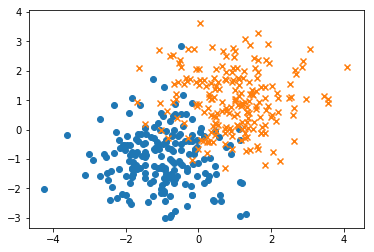

In [11]:
np.random.seed(42)   # supprimer cette ligne une fois la mise au point terminée

# Un autre exemple d'utilisation:

autre_desc, autre_label = ut.genere_dataset_gaussian(np.array([1,1]),np.array([[1,0],[0,1]]), \
                                                     np.array([-1,-1]),np.array([[1,0],[0,1]]),\
                                                     200)

print("Le dataset généré avec ", np.shape(autre_desc)[0], "lignes de ", np.shape(autre_desc)[1], "colonnes.")

# Affichage :
ut.plot2DSet(autre_desc,autre_label)

# Classifieur :
knn = cl.ClassifierKNN(2,3)

res_apprentissage, res_test = crossvalidation(knn, (autre_desc, autre_label), 5)

print("(moyenne, std) pour apprentissage :", res_apprentissage)
print("(moyenne, std) pour test          :", res_test)

Lorsqu'on compare plusieurs classifieurs, il est intéressant de mesurer leurs performances par une validation croisée, et idéalement, réalisée avec les mêmes datasets.

<font color="RED" size="+1">**[Q]**</font> Réécrire la fonction précédente pour qu'elle prenne en argument non pas un seul classifieur, mais une liste de classifieurs et qu'elle renvoie la liste des quadruplets résultats correspondante.

*Attention*: il ne s'agit pas d'écrire une fonction qui appelle la fonction précédente, **il faut la réécrire**.

#### Remarque:
pour certains classifieurs, il peut être nécessaire de réinitialiser le classifieur avant de lancer un nouvel apprentissage avec un nouveau dataset. 

Une façon élégante de faire cela est de définir une nouvelle méthode dans la classe `Classifier` qui permet de réinitiliser le classifieur, on appelle `reset` cette méthode qui, par défaut, ne fera rien (instruction `pass` de python).

Rajouter la méthode suivante dans votre classe `Classifier` du fichier `Classifier.py`:

    def reset(self):
        """ réinitialise le classifieur si nécessaire avant un nouvel apprentissage
        """
        # en général, cette méthode ne fait rien :
        pass
        # dans le cas contraire, on la redéfinit dans le classifier concerné
        
Cette méthode est appelable par toute instance d'une classe héritant de `Classifier`.

Des classifieurs que l'on a implémentés jusqu'à présent, seul le `ClassifierPerceptron` est concerné par une réinitialisation:
- le vecteur de poids initiaux `self.w` est tiré aléatoirement à la création du classifieur. Le mieux est donc de générer ce vecteur dans le constructeur du perceptron. Afin de pouvoir retrouver les valeurs initiales de ce vecteur, il faut donc aussi, dans le constructeur, initialiser une autre variable de la classe que l'on peut appeler `self.w_init` et qui sauvegarde donc ces valeurs initiales de `self.w`;
- dans la méthode `reset` que l'on redéfinie dans le perceptron, on remet dans `self.w` les valeurs contenues dans `self.w_init`:

        def reset(self):
            """ réinitialise le classifieur si nécessaire avant un nouvel apprentissage
            """
            # les poids sont remis à leur valeurs initiales:
            self.w = self.w_init


Avant de réécrire la méthode `crossvalidation`, modifier les classes du fichier `Classifiers.py` afin de prendre en compte cette modification.


#### Pour être complet:
Rajouter dans chaque classe de la hiérarchie `Classifier` une méthode `toString` pour obtenir, sous forme de chaîne de caractère, les informations sur le classifieur, cette méthode est spécifiée par:

        def toString(self):
            """  -> str
                rend le nom du classifieur avec ses paramètres
            """


In [12]:
def crossvalidation(LC, DS, m, debug=True):
    """ List[Classifieur] * tuple[array, array] * int ->  List[tuple[tuple[float,float], tuple[float,float]]]
        Hypothèse: m>0
        Par défaut, m vaut 10
    """
    
    data_desc, data_labels = DS[0], DS[1]
    indices = [i for i in range(len(data_desc))]
    train_accs = []
    test_accs = []
    m_indices = []
    length = len(data_desc) // m
    
    for i in range(len(LC)):
        train_accs.append([])
        test_accs.append([])
    
        
    for i in range(m): # we're not treating the case where m%len(DS) != 0 (if the rest has a size = 1, it'll kill the avg)
        # random tirage
        np.random.shuffle(indices)
        
        m_indices.append([i for i in indices[:length]])

        # remove the first length indices so that we don't take the same description twice
        for j in range(length):
            indices.pop(0)
            
    # take one for training, the others for testing
    for test_index in range(m):
        # getting the training indices in each iteration
        train_indices = list(chain.from_iterable([m_indices[i] for i in range(m) if i != test_index])) 
        
        for i in range(len(LC)):
            LC[i].train(data_desc[train_indices], data_labels[train_indices])

            # append training accuracy to the training_set
            train_accs[i].append(LC[i].accuracy(data_desc[train_indices], data_labels[train_indices]))

            # append test accuracy to the test_set
            test_accs[i].append(LC[i].accuracy(data_desc[m_indices[test_index]], data_labels[m_indices[test_index]]))    
    
    if debug:
        print("Il y a ", len(LC), "classifieurs à comparer.")
        for i in range(len(LC)):
            print("[Info debug] Classifieur   ", i)
            print("[Info debug] liste accuracies Apprentissage: ", train_accs[i])
            print("[Info debug] liste accuracies Test         : ", test_accs[i])
            print()

    for i in range(len(LC)):
        train_accs[i] = np.array(train_accs[i])
        test_accs[i] = np.array(test_accs[i])
    
    returned_values = [((tr.mean(), tr.std()), (ts.mean(), ts.std())) for tr, ts in zip(train_accs, test_accs)]
    
    return returned_values

In [7]:
# Exemple d'utilisation:

# Un autre exemple d'utilisation :
Liste_Classifiers = []
Liste_Classifiers.append(cl.ClassifierKNN(2,1))
Liste_Classifiers.append(cl.ClassifierKNN(2,3))

Liste_Classifiers.append(cl.ClassifierPerceptron(2,0.01))

Resultats = crossvalidation(Liste_Classifiers, (autre_desc, autre_label), 10)

print("\n*****\nAffichage des résultats:")
for k in range(0,len(Resultats)):
    print("Classifieur ", Liste_Classifiers[k].toString())
    print("\t(moyenne, std) pour apprentissage :", Resultats[k][0])
    print("\t(moyenne, std) pour test          :", Resultats[k][1])



[Info debug] Classifieur  0
[Info debug] liste accuracies Apprentissage:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[Info debug] liste accuracies Test         :  [0.85, 0.9, 0.85, 0.925, 0.9, 0.825, 0.875, 0.925, 0.85, 0.85]

[Info debug] Classifieur  1
[Info debug] liste accuracies Apprentissage:  [0.9416666666666667, 0.9416666666666667, 0.9333333333333333, 0.9444444444444444, 0.9416666666666667, 0.95, 0.9472222222222222, 0.9333333333333333, 0.9361111111111111, 0.9416666666666667]
[Info debug] liste accuracies Test         :  [0.925, 0.925, 0.95, 0.9, 0.9, 0.85, 0.875, 1.0, 0.925, 0.925]

[Info debug] Classifieur  2
[Info debug] liste accuracies Apprentissage:  [0.9166666666666666, 0.9111111111111111, 0.9138888888888889, 0.9138888888888889, 0.9138888888888889, 0.9166666666666666, 0.9166666666666666, 0.9055555555555556, 0.9083333333333333, 0.9138888888888889]
[Info debug] liste accuracies Test         :  [0.875, 0.925, 0.9, 0.9, 0.9, 0.85, 0.9, 0.975, 0.925, 0.95]

*****
Affi

<font color="RED" size="+1">**[Q]**</font> A l'aide d'une validation croisée en 10 paquets réalisée sur un dataset généré aléatoirement, donner les performances (accuracy moyenne et écart type) de tous les classifieurs implémentés depuis le TME 2.

In [ ]:
# ------------------------ A COMPLETER :


### Expérimentations de  classifieurs sur des données réelles

Téléchargez des données réelles (voir les TME précédents) et réalisez un ensemble d'expérimentations permettant de comparer les classifieurs que vous avez implémentés depuis le TME 2. 
Comparez-les en termes d'accuracy, de temps d'exécution,...
Attention, il est donc nécessaire dans cette partie d'inclure des boîtes de code python pour faire les tests mais aussi des boîtes de texte, pour expliquer l'objectif des expériences, ainsi que d'autres boîtes pour commenter les résultats obtenus.

## Visualisation des données

Lorsque les données sur lesquelles on travaille possèdent plus de 2 dimensions, il n'est pas facile de les visualiser simplement comme on a pu le faire dans les séances précédentes en utilisant un plot.

Une façon de mieux visualiser ces données peut être d'utiliser les outils d'un package de visualisation.

Le package <code>seaborn</code> est très pratique (vous pouvez consulter la documentation sur le web) et généralement installé dans l'environnement Python.

In [8]:
# Importation du package seaborn:
import seaborn as sns

Pour travailler avec `seaborn`, on a besoin de mettre le dataset dans un `DataFrame` pandas :

In [9]:
# On commence par créer un dataframe avec les descriptions :
df = pd.DataFrame(autre_desc, columns= ["X", "Y"])

# puis on rajoute au dataframe une nouvelle colonne contenant les labels de chaque exemple :
df['label'] = autre_label

# Affichage du dataframe obtenu:
df

,X,Y,label
0,-0.503286,-1.138264,-1
1,-0.352311,0.523030,-1
2,-1.234153,-1.234137,-1
3,0.579213,-0.232565,-1
4,-1.469474,-0.457440,-1
...,...,...,...
395,1.429618,1.207688,1
396,1.271579,-0.276749,1
397,-0.081057,2.053153,1
398,0.960445,1.681501,1


On utilise ici la fonction <code>pairplot</code> du package `seaborn` pour construire un corrélogramme qui affiche les corrélations des dimensions prises 2 à 2.

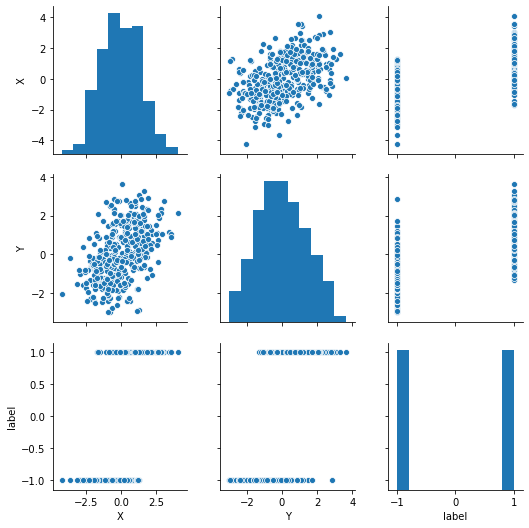

In [10]:
sns.pairplot(df)

# Eventuellement, mais pas nécessairement utile:
#sns.plt.show()

<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction `cree_dataframe()` qui, étant donné un dataset (un tuple contenant un array avec les description et un array avec les labels correspondant) et une liste de chaîne de caractères donnant les noms des variables correspondant à chaque colonne de la description, ainsi qu'une chaîne de caractères donnant le nom pour la colonne label à donner dans le dataframe créé (ce dernier argument étant optionnel et mis à la chaîne "label" par défaut), rend le dataframe correspondant.

In [ ]:
# ------------------------ A COMPLETER :
def cree_dataframe(DS, L_noms, Nom_label = "label"):
    """ Dataset * List[str] * Str -> DataFrame
        Hypothèse: la liste a autant de chaînes que la description a de colonnes
    """
    
    raise NotImplementedError("Please Implement this method")


In [12]:
cree_dataframe((autre_desc,autre_label),["X", "Y"])

,X,Y,label
0,-0.503286,-1.138264,-1
1,-0.352311,0.523030,-1
2,-1.234153,-1.234137,-1
3,0.579213,-0.232565,-1
4,-1.469474,-0.457440,-1
...,...,...,...
395,1.429618,1.207688,1
396,1.271579,-0.276749,1
397,-0.081057,2.053153,1
398,0.960445,1.681501,1


In [13]:
df_data = cree_dataframe((data_desc,data_label),["Abscisse", "Ordonnée"], 'classe')
df_data

,Abscisse,Ordonnée,classe
0,-0.503286,-1.138264,-1
1,-0.352311,0.523030,-1
2,-1.234153,-1.234137,-1
3,0.579213,-0.232565,-1
4,-1.469474,-0.457440,-1
5,-1.463418,-1.465730,-1
6,-0.758038,-2.913280,-1
7,-2.724918,-1.562288,-1
8,-2.012831,-0.685753,-1
9,-1.908024,-2.412304,-1


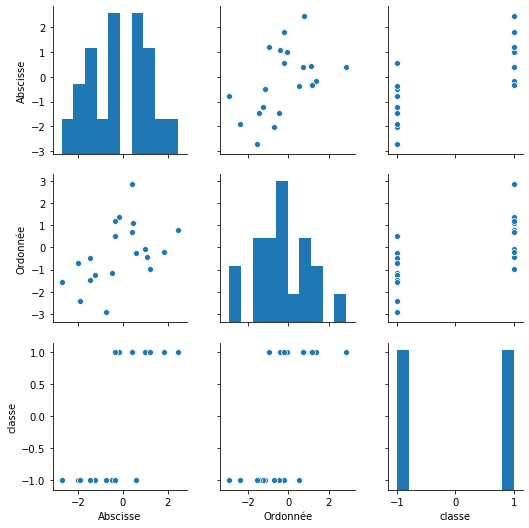

In [14]:
sns.pairplot(df_data)

Un autre exemple, qui utilise un dataset classique en apprentissage: le dataset des iris de Fisher  (voir par exemple : https://fr.wikipedia.org/wiki/Iris_de_Fisher) dont les exemples sont décrits par 4 variables et sont associés à l'une des 3 classes possibles ('setosa', 'virginica' et 'versicolor').

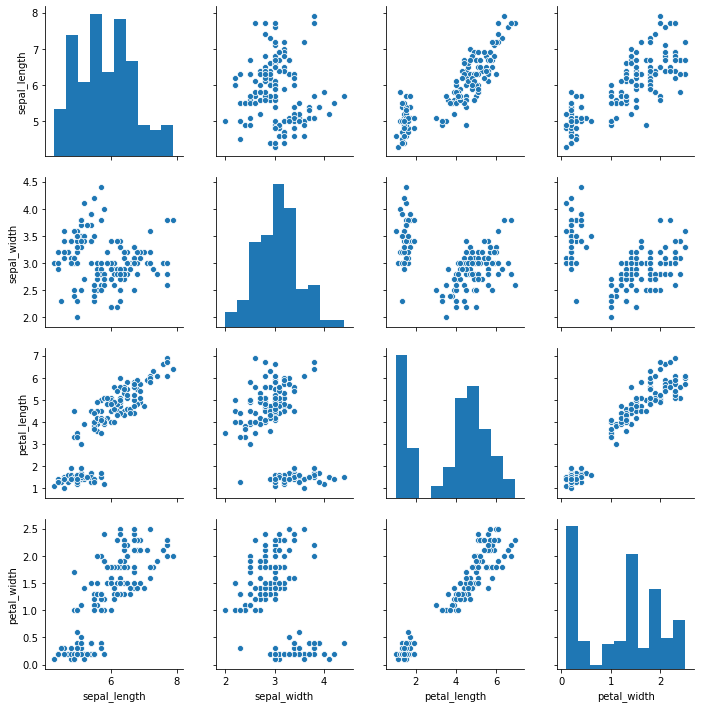

In [15]:
# Le dataset des iris est fourni dans le package seaborn, on l'obtient ainsi:
df_iris = sns.load_dataset('iris')

# On peut alors construire le corrélogramme de ce dataset:
sns.pairplot(df_iris)

In [16]:
df_iris['species']

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object

<font color="RED" size="+1">**[Q]**</font> Utiliser le package `seaborn` ainsi que les fonctions statistiques vues lors du TME 1 pour afficher tout un ensemble de résultats permettant d'analyser la base des Iris de Fisher. 

<font color="RED" size="+1">**[Q]**</font> Afin de pouvoir utiliser les classifieurs sur la base des Iris, il est nécessaire de l'adapter : ce dataset contient 3 classes (qui sont des chaînes) alors que les classifieurs implémentés précédemment sont binaires (et travaillent sur les labels -1 et +1).
Le moyen le plus simple est de réaliser un apprentissage **one vs all** :
- choisir une classe et lui donner le label +1
- toutes les autres classes sont alors associées au label -1

Mettre au point une série d'expérimentation pour tester les algorithmes sur la base des iris en utilisant ce codage. Tester en particulier s'ils sont sensibles aux bases de données déséquilibrées (dans lesquelles une classe est plus présente que les autres) et si c'est le cas adapter le cadre **one vs all** en sous-échantillonnant les "all" pour en prendre autant d'exemple d'apprentissage que les "one", faire de même pour les données de test.